# One-Qubit-Classifier



With the following code a linear separable 2dim dataset can be classified.

The original idea and some code snippets stem from "NISQAI: One-Qubit Quantum Classifier" by 
Ryan LaRose, Yousif Almulla, Nic Ezzell, Joe Iosue, Arkin Tikku, https://github.com/QuantumAI-lib/NISQAI/tree/master/examples/one-qubit-classifier

They however used pyQuil for implementation.

The modification and transformation to Qiskit has been done by Gerhard Hellstern, ghellstern@gmx.de

In [1]:
from qiskit import *
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from qiskit import Aer
# See a list of available local simulators
print("Aer backends: ", Aer.backends())
backend_state = Aer.get_backend('statevector_simulator')
backend_sim = Aer.get_backend('qasm_simulator')

Aer backends:  [<QasmSimulator('qasm_simulator') from AerProvider()>, <StatevectorSimulator('statevector_simulator') from AerProvider()>, <UnitarySimulator('unitary_simulator') from AerProvider()>]


### Generating data

Generate 2 dimensional random date in [0,1]x[0,1]. Label the left half of the square with 1 and the second one with 0.

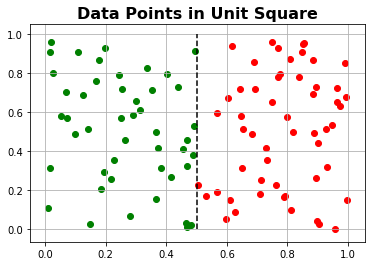

In [3]:
np.random.seed(seed=12345)
n = 100
data = np.random.rand(n, 2)

label=np.zeros(n)

for p in range(0,n):
    if data[p,0] <= 0.5:
        label[p]=1

# plot the line y = x
xs = np.linspace(0, 1, 100)
ys = 0.5 * np.ones_like(xs)
plt.plot(ys, xs, '--k')

for i in range(n):
    if label[i] == 0:
        ckey = 'r'
    else:
        ckey = 'g'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)
    
# title and axis lables
plt.title("Data Points in Unit Square", fontweight="bold", fontsize=16)

# put on a grid and show the plot
plt.grid()
plt.show()
        



### Qubit Encoding

Here we implement a method of data encoding that we call "qubit encoding." Qubit encoding works by writing two bits of classical information into one bit of quantum information. How is this done? Note that any qubit can be written

\begin{equation}
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
\end{equation}

where $\alpha, \beta \in \mathbb{C}$ satisfying $|\alpha|^2 + |\beta|^2 = 1$. Because of this normalization condition, we may equivalently write

\begin{equation}
|\psi\rangle = \cos(\theta / 2) |0\rangle + e^{i \phi} \sin(\theta / 2)|1\rangle
\end{equation}

We then encode information into the phases $0 \le \theta \le \pi$ and $ 0 \le \phi \le 2 \pi$. 

For the $(x, y)$ coordinates of our points, there are several possibilities for encoding:

\begin{align}
\theta &= \pi x \\
\phi &= 2 \pi y
\end{align}

Another encoding is:

\begin{align}
\theta &= \frac{1}{2} \tan^{-1}\left( \frac{y}{x} \right) \\
\phi &= \pi (x^2 + y^2),
\end{align}

In code, we may make these transformations as follows:

In [4]:
qdata1 = np.zeros((n, 2))

for (index, point) in enumerate(data):
    qdata1[index][0] = np.pi * point[0]
    qdata1[index][1] = 2 * np.pi * point[1]

In [5]:
qdata2 = np.zeros((n, 2))

for (index, point) in enumerate(data):
    qdata2[index][0] = 0.5*np.arctan(point[1]/point[0])
    qdata2[index][1] = np.pi*(point[0]**2 + point[1]**2)

In [6]:
## To switch between the two encoding possibilities
qdata=qdata1

### State Preparation
Starting from the ground state $|0\rangle$ state and given angles $\theta, \phi$ state preparatiob can be performed via:

\begin{equation}
S(\theta, \phi) |0\rangle \rightarrow |\psi\rangle = \cos(\theta / 2) |0\rangle + e^{i \phi} \sin(\theta / 2)|1\rangle
\end{equation}

where $S$ is a _state preparation unitary_ or _state preparation circuit_.

It is clear from the equation above that the matrix representation for $S$ in the computational basis is

\begin{equation}
S(\theta, \phi) = \left[ \begin{matrix} 
\cos(\theta / 2) & e^{-i \phi} \sin(\theta / 2)\\
e^{i \phi} \sin(\theta / 2) & - \cos(\theta / 2)  \\
  \end{matrix} \right]
\end{equation}

Using Qiskit, one possibility for stae preparation is using the u3-gate:
\begin{equation}
u_3 = u_3(\theta,\pi, \pi-\phi)
\end{equation}


After the classical data has been encoded and prepared into the quantum system, the next step is to perform unitary evolution on the quantum state representing the data. In the language of classical learning theory, this corresponds to implementing a layer of the neural network.

In the quantum neural network case, we simply need to implement a sequence of parameterized gates.

Again, in Qiskit the u3-gate can be used for this purpose.

In [7]:
qr = QuantumRegister(1,'q0')
cr = ClassicalRegister(1,'c0')

def make_program(pangles, uangles):
    """Returns a program that prepares the state according
    to pangles and applies the unitary according to uangles.
    """
    # instantiate a program
    circuit0=QuantumCircuit(qr, cr)

    # define a gate in Qiskit for the state preparation
    circuit0.u3(pangles[0], pangles[1],np.pi-pangles[1],qr)
    
#    unitary(circuit0,uangles)
    circuit0.u3(uangles[0], uangles[1],np.pi-uangles[1],qr)
    return circuit0

In [8]:
def obj_simple(angles):
    """Returns the number of zero outputs of a single training example."""
    # make the program
    circuit1=make_program([theta, phi], angles)

    circuit1.measure(qr, cr)
    job_sim = execute(circuit1, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(circuit1)
    res_1=result_counts.get('1')
    if res_1==None:
        res_1=0
    res_0=result_counts.get('0')
    if res_0==None:
        res_0=0
    obj=res_1/(res_0+res_1)

    print("The current value of the objective function is:", obj, end="\r")
    return obj

### Training

To faciliate training an  _indicator function_ $I(z_i = \hat{z}_i)$ = 0 if $z_i = \hat{z}_i$ and 1 otherwise is definied. Here, $z_i$ is the exact label of the $i$th training data $(x_i, y_i)$ and $\hat{z}_i$ is the prediction of this label by our neural network. (In code, we use the variables `labels` for $z_i$ and `predictions` for $\hat{z}_i$.)

To define the total cost, sum over all points in the training data:

\begin{equation}
C = \sum_{i = 1}^{M} I(z_i = \hat{z}_i)
\end{equation}


In [9]:
# fraction of total data to use as training data
train_frac = 0.7

def obj(uangles):
    """Returns the objective function C defined above over all training data.
    
    Args:
        uangles [type: list<float>]
            the angles in the unitary evolution.

    rtype: float
    """
    # grab some training data from the overall data set
    tpoints = int(train_frac * len(qdata))
    tdata = qdata[:tpoints]
    tlabels = label[:tpoints]
    
    # initialize a variable to store the output predictions of the neural net
    predictions = np.zeros_like(tlabels, dtype=int)
    
    # loop over all training data to get the predictions
    for i, pangles in enumerate(tdata):
        circuit1=make_program(pangles, uangles)
        circuit1.measure(qr, cr)
        job_sim = execute(circuit1, backend_sim)
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(circuit1)
        res_1=result_counts.get('1')
        if res_1==None:
            res_1=0
        res_0=result_counts.get('0')
        if res_0==None:
            res_0=0
        p0=res_0/(res_0+res_1)
        p1=res_1/(res_0+res_1)
        # take the prediction to be max(p0, p1)
        if p0 >= p1:
            predictions[i] = 0
        else:
            predictions[i] = 1
        
    # compute the difference of the labels and return the cost
    cost = sum(abs(predictions - tlabels)) / tpoints
    print("The current value of the cost function is:", cost, end="\r")
    return cost

In [10]:
# train the quantum neural network and time how long it takes
# get some random angles
angs = 2 * np.pi * np.random.rand(2)
out = minimize(fun=obj, x0=angs, method="Powell")


In [11]:
# grab the optimal angles and minimal cost value
optimal_angles = out['x']
fval = out['fun']

# print them out
print(fval)
print(optimal_angles)

0.0
[3.17067419 3.64657332]


### Predictions

Calculatee predictions on the whole dataset.



In [12]:
def get_all_predictions(angles):
    """Returns a numpy array of all predictions."""
    # initialize a variable to store the output predictions of the neural net
    zhats = np.zeros_like(label, dtype=int)
    
    # loop over all data to get predictions
    for i, pangles in enumerate(qdata):
        circuit1=make_program(pangles, angles)
        circuit1.measure(qr, cr)
        job_sim = execute(circuit1, backend_sim)
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(circuit1)
        res_1=result_counts.get('1')
        if res_1==None:
            res_1=0
        res_0=result_counts.get('0')
        if res_0==None:
            res_0=0
        p0=res_0/(res_0+res_1)
        p1=res_1/(res_0+res_1)

        # take the prediction to be max(p0, p1)
        if p0 >= p1:
            zhats[i] = 0
        else:
            zhats[i] = 1
    return zhats

In [13]:
# compute all the predictions of the quantum neural network
predictions = get_all_predictions(optimal_angles)

=============== Results of quantum neural network classification ===============
Out of 100 total data points:
The QNN was trained on 70.0% of the total data (70 training points).
The QNN classified 100.0 data points correctly (100.0% accuracy).


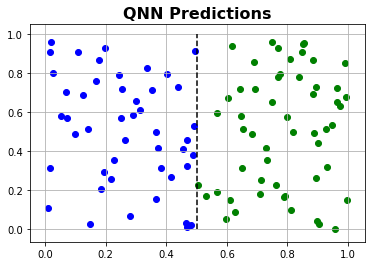

In [14]:
# compute statistics of the QNN
ntrain = int(train_frac * n)
ncorrect = n - sum(abs(predictions - label))
acc = ncorrect / n * 100

# print them out
print(" Results of quantum neural network classification ".center(80, "="))
print("Out of {} total data points:".format(n))
print("The QNN was trained on {}% of the total data ({} training points).".format(train_frac * 100, ntrain))
print("The QNN classified {} data points correctly ({}% accuracy).".format(ncorrect, acc))
print("".center(80, "="))

# plot the points, line y = x, and prediction
plt.plot(ys, xs, '--k')
for i in range(n):
    if predictions[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)

plt.grid()
plt.title("QNN Predictions", fontsize=16, fontweight="bold")
plt.show()